# Get Passer Rating data by Play from DB

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt

%matplotlib inline

config = {
'user': 'db_gtown_2018',
'password': 'Gtown2018',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT 
PASSER.PNAME AS PASSER
, CONCAT(PASSER.PNAME, ', ', GAME.SEAS) AS PASSER_SEAS
, CASE WHEN PASSER_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS PASSER_PRO_BOWL

, CASE WHEN PASSER.DPOS > 0
THEN PASSER.DPOS
ELSE 256
END AS PASSER_DRAFT_SPOT
, CASE WHEN PASSER.DPOS > 0
THEN 1
ELSE 0
END AS PASSER_DRAFTED 

,TARGET.PNAME AS TARGET
,CASE WHEN PASS_FULL.LOC IN ('DL', 'DM', 'DR')
THEN 1
ELSE 0
END AS DEEP_PASS
,CASE WHEN PASS_FULL.LOC IN ('L', 'M', 'R', 'NL')
THEN 1
ELSE 0
END AS MED_PASS
,CASE WHEN PASS_FULL.LOC IN ('SL', 'SM', 'SR')
THEN 1
ELSE 0
END AS SHORT_PASS
, PASS_FULL.YDS
, 1 AS PASS_ATTEMPT
, PASS_FULL.COMP
, PASS_FULL.TD
, PASS_FULL.INTRCPT
, PASSER_RATING.PASS_RAT
, PASSER.HEIGHT AS PASSER_HGHT
, GAME.SEAS - RIGHT(PASSER.DOB,4) AS PASSER_AGE
, PASSER.START AS PASSER_CAREER_STRT
/*, GAME.SEAS - */
, TARGET.HEIGHT AS TGT_HGHT
, TARGET.WEIGHT AS TGT_WGHT
, CASE WHEN TARGET_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS TARGET_PRO_BOWL

, GAME.SEAS - RIGHT(TARGET.DOB,4) AS TGT_AGE
, CASE WHEN TARGET.DPOS IS NULL
THEN 256
WHEN TARGET.DPOS = 0
THEN 256
ELSE TARGET.DPOS
END AS TGT_DRAFT_SPOT
, CASE WHEN TARGET.DPOS > 0
THEN 1
ELSE 0
END AS TGT_DRAFTED 
, TARGET.START AS TGT_CAREER_STRT /*'USE TO FIGURE OUT YEARS IN LEAGUE'*/
, CASE WHEN TARGET.FORTY = 0
THEN ROUND(AVERAGE_FORTY.AVG_FORTY,3)
ELSE TARGET.FORTY
END AS TGT_FORTY
, CASE WHEN TARGET.VERTICAL = 0
THEN ROUND(AVERAGE_VERTICAL.AVG_VERT,3)
ELSE TARGET.VERTICAL
END AS TGT_VERT
, CASE WHEN TARGET.POS1 = 'RB'
THEN 1
ELSE 0
END AS RB_TGT
, CASE WHEN TARGET.POS1 = 'WR'
THEN 1
ELSE 0
END AS WR_TGT
, CASE WHEN TARGET.POS1 = 'TE'
THEN 1
ELSE 0
END AS TE_TGT
, CASE WHEN TARGET.POS1 <> 'RB'
AND TARGET.POS1 <> 'TE'
AND TARGET.POS1 <> 'WR'
THEN 1
ELSE 0
END AS TRICK_PLAY

/*,QTR
,MIN *//*'CAN BE USED FOR TWO MIN DRILL'*/
, YTG
, Case when PASS_FULL.YDS >= YTG
THEN 1
ELSE 0
END AS FIRST_DOWN_CONVERSION

, CASE WHEN ZONE = 5
THEN 1
ELSE 0
END AS RED_ZONE_ATTMPT /*'DEFINITION AVAILABLE'*/
, CASE WHEN ZONE = 5
THEN PASSER_RATING.PASS_RAT
ELSE NULL
END AS RED_ZONE_QB_RAT /*'DEFINITION AVAILABLE'*/
, CASE WHEN DWN = 4
AND PASS_FULL.YDS >= YTG
THEN 1
when DWN = 4
AND PASS_FULL.YDS < YTG
THEN 0
ELSE NULL
END
AS FOURTH_DOWN_SUCCESS
, CASE WHEN DWN = 3
AND PASS_FULL.YDS >= YTG
THEN 1
when DWN = 3
AND PASS_FULL.YDS < YTG
THEN 0
ELSE NULL
END
AS THIRD_DOWN_SUCCESS
, CASE WHEN QTR = 4
THEN PASSER_RATING.PASS_RAT
ELSE null
END AS FOURTH_QTR_PASS_RAT
, CASE WHEN SG = 'Y'
THEN 1 
ELSE 0
END as SHOTGUN
, CASE WHEN NH = 'Y'
THEN 1
ELSE 0
END AS  NO_HUDDLE
, CASE WHEN PENALTY.ACT IS NOT NULL
THEN 1
ELSE 0
END AS DEF_PENALTY_DCLND
,CASE WHEN PENALTY.ACT IS NOT NULL
THEN PASSER_RATING.PASS_RAT
ELSE NULL
END AS FREE_PLAY_PASS_RAT
, PENALTY.DESC as PENALTY_DESC
,GAME.SEAS
/* ,GAME.WK
,GAME.DAY
,GAME.V 'FIGURE OUT HOW TO DO HOME OR AWAY'
,GAME.H*/
/*HOW DO WE CALCULATE WHETHER THE PASSER IS AT HOME OR AWAY?*/
,GAME.TEMP
,GAME.HUMD
,GAME.WSPD
,case when COND IN ('Rain', 'Showers', 'Snow', 'Thunderstorms', 'Cold'
,'Flurries'
,'Light Rain'
,'Light Showers'
,'Light Snow'
,'Windy'
)
THEN 1
ELSE 0
END AS BAD_WEATH
, case when COND IN ('Chance Rain'
,'Clear'
,'Closed Roof'
,'Cloudy'
,'Covered Roof'
,'Dome'
,'Fair'
,'Foggy'
,'Hazy'
,'Mostly Cloudy'
,'Mostly Sunny'
,'Overcast'
,'Partly Cloudy'
,'Partly Sunny'
,'Sunny' )
THEN 1
WHEN COND IS NULL
THEN 1
ELSE 0
END AS GOOD_WEATH
,GAME.COND
, CASE WHEN GAME.COND = 'DOME'
THEN 1
ELSE 0
END AS DOME_GAME
, CASE WHEN GAME.SURF <> 'GRASS'
THEN 1
ELSE 0
END AS TURF_FIELD
 FROM PBP
 INNER JOIN PASS_FULL
 ON PBP.PID = PASS_FULL.PID
left outer join GAME
ON PBP.GID = GAME.GID
LEFT OUTER JOIN PENALTY
ON PBP.PID = PENALTY.PID
AND PENALTY.CAT = '4'
AND PENALTY.ACT = 'D'
INNER JOIN PLAYER PASSER
ON PASS_FULL.PSR = PASSER.PLAYER
LEFT OUTER JOIN PLAYER TARGET
ON PASS_FULL.TRG = TARGET.PLAYER
LEFT OUTER JOIN PASSER_RATING
ON PASS_FULL.YDS = PASSER_RATING.YDS
AND PASS_FULL.COMP = PASSER_RATING.COMPL
AND PASS_FULL.TD = PASSER_RATING.TD
AND PASS_FULL.INTRCPT = PASSER_RATING.INTRCPT
LEFT OUTER JOIN (SELECT 
POS1
, AVG(FORTY) AS AVG_FORTY
,COUNT(*)
FROM PLAYER
WHERE FORTY > 0
GROUP BY 
POS1) AVERAGE_FORTY
ON TARGET.POS1 = AVERAGE_FORTY.POS1
LEFT OUTER JOIN
(SELECT 
POS1
, AVG(VERTICAL) AS AVG_VERT
,COUNT(*)
FROM PLAYER
WHERE VERTICAL > 0
GROUP BY 
POS1) AVERAGE_VERTICAL
ON TARGET.POS1 = AVERAGE_VERTICAL.POS1
LEFT OUTER JOIN PRO_BOWL PASSER_PRO_BOWL
ON GAME.SEAS = PASSER_PRO_BOWL.ProBowl_Year
AND PASSER.PLAYER = PASSER_PRO_BOWL.PLAYER_ID
LEFT OUTER JOIN PRO_BOWL TARGET_PRO_BOWL
ON GAME.SEAS = TARGET_PRO_BOWL.ProBowl_Year
AND TARGET.PLAYER = TARGET_PRO_BOWL.PLAYER_ID
WHERE PASS_FULL.SPK = 0
AND GAME.SEAS < 2017


"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [2]:
df.columns = ['PASSER', 
'PASSER_SEAS',
'PASSER_PRO_BOWL', 
'PASSER_DRAFT_SPOT', 
'PASSER_DRAFTED', 
'TARGET', 
'DEEP_PASS', 
'MED_PASS', 
'SHORT_PASS', 
'YDS', 
'PASS_ATTEMPT',
'COMP', 
'TD', 
'INTRCPT', 
'PASS_RAT', 
'PASSER_HGHT', 
'PASSER_AGE', 
'PASSER_CAREER_STRT', 
'TGT_HGHT', 
'TGT_WGHT', 
'TARGET_PRO_BOWL', 
'TGT_AGE', 
'TGT_DRAFT_SPOT', 
'TGT_DRAFTED', 
'TGT_CAREER_STRT', 
'TGT_FORTY', 
'TGT_VERT', 
'RB_TGT', 
'WR_TGT', 
'TE_TGT', 
'TRICK_PLAY', 
'YTG', 
'FIRST_DOWN_CONVERSION', 
'RED_ZONE_ATTMPT', 
'RED_ZONE_QB_RAT', 
'FOURTH_DOWN_SUCCESS', 
'THIRD_DOWN_SUCCESS', 
'FOURTH_QTR_PASS_RAT', 
'SHOTGUN', 
'NO_HUDDLE', 
'DEF_PENALTY_DCLND', 
'FREE_PLAY_PASS_RAT', 
'PENALTY_DESC', 
'SEAS', 
'TEMP', 
'HUMD', 
'WSPD', 
'BAD_WEATH', 
'GOOD_WEATH', 
'COND', 
'DOME_GAME', 
'TURF_FIELD'
]

In [3]:
df.head(5)

,PASSER,PASSER_SEAS,PASSER_PRO_BOWL,PASSER_DRAFT_SPOT,PASSER_DRAFTED,TARGET,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,PENALTY_DESC,SEAS,TEMP,HUMD,WSPD,BAD_WEATH,GOOD_WEATH,COND,DOME_GAME,TURF_FIELD
0,V.Testaverde,"V.Testaverde, 2000",0,1,1,M.Coleman,0,1,0,45,...,None,2000,68,74,12,0,0,,0,0
1,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0,1,0,0,...,None,2000,90,50,8,0,1,Mostly Sunny,0,0
2,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0,1,0,0,...,None,2000,90,50,8,0,1,Mostly Sunny,0,0
3,C.McNown,"C.McNown, 2000",0,12,1,C.Villarrial,0,1,0,0,...,None,2000,65,0,0,0,1,Dome,1,1
4,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0,1,0,6,...,None,2000,90,50,8,0,1,Mostly Sunny,0,0


## Per Pass passer rating distribution

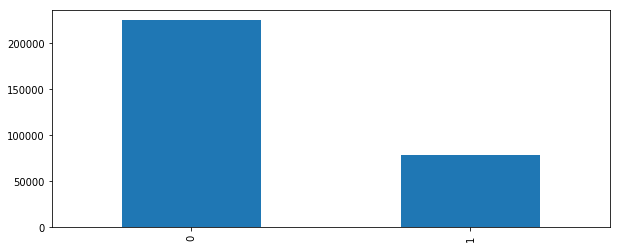

In [4]:
plt.figure(figsize=(10,4))
df["PASSER_PRO_BOWL"].value_counts().plot(kind='bar')

In [5]:
#Too many pass attemps, lets group them group into a per season/passer
#df.groupby(['PASSER', 'SEAS']).size()

df_passer_by_season = df.groupby(['PASSER', 'SEAS']).agg({
    'PASSER': np.min, 
    'PASSER_SEAS': np.min, 
    'PASSER_PRO_BOWL': np.max, 
    'PASS_RAT': np.mean, 
    'PASS_ATTEMPT': np.size,
    'COMP': np.sum,
    'PASSER_DRAFT_SPOT': np.max, 
    'PASSER_DRAFTED': np.max, 
    'DEEP_PASS': np.mean,  
    'MED_PASS': np.mean, 
    'SHORT_PASS': np.mean, 
    'YDS': np.sum, 
    'TD': np.sum, 
    'INTRCPT': np.sum, 
    'PASSER_HGHT': np.max,  
    'PASSER_AGE': np.max, 
    'PASSER_CAREER_STRT': np.max, 
    'TGT_HGHT': np.mean, 
    'TGT_WGHT': np.mean, 
    'TARGET_PRO_BOWL': np.mean,  
    'TGT_AGE': np.mean, 
    'TGT_DRAFT_SPOT': np.mean, 
    'TGT_DRAFTED': np.mean, 
    'TGT_CAREER_STRT': np.mean, 
    'TGT_FORTY': np.mean,  
    'TGT_VERT':np.mean, 
    'RB_TGT': np.mean,  
    'WR_TGT': np.mean, 
    'TE_TGT': np.mean,  
    'TRICK_PLAY': np.mean, 
    'FIRST_DOWN_CONVERSION': np.mean, 
    'RED_ZONE_ATTMPT': np.mean, 
    'RED_ZONE_QB_RAT': np.mean , 
    'FOURTH_DOWN_SUCCESS': np.mean, 
    'THIRD_DOWN_SUCCESS': np.mean, 
    'FOURTH_QTR_PASS_RAT': np.mean,  
    'SHOTGUN': np.mean,  
    'NO_HUDDLE': np.mean, 
    'DEF_PENALTY_DCLND': np.sum, 
    'FREE_PLAY_PASS_RAT': np.mean,  
    'SEAS': np.max,  
    'GOOD_WEATH': np.mean,  
    'DOME_GAME': np.mean,  
    'TURF_FIELD': np.mean,                               
    'SEAS': np.min,
                                   })


##df_passer_by_season = df.groupby(['PASSER', 'SEAS']).agg({'PASSER': { 'PASSER_NAME': np.min, 'PASS_ATTEMPTS': np.size}, 'PASSER_PRO_BOWL': np.max, 'PASS_RAT': np.mean, 'COMP': np.sum,  'PASSER_DRAFT_SPOT': np.max, 'PASSER_DRAFTED': np.max, 'DEEP_PASS': np.mean,  'MED_PASS': np.mean, 'SHORT_PASS': np.mean, 'YDS': np.sum, 'TD': np.sum, 'INTRCPT': np.sum, 'PASSER_HGHT': np.max,  'PASSER_AGE': np.max, 'PASSER_CAREER_STRT': np.max, 'TGT_HGHT': np.mean, 'TGT_WGHT': np.mean, 'TARGET_PRO_BOWL': np.mean,  'TGT_AGE': np.mean, 'TGT_DRAFT_SPOT': np.mean, 'TGT_DRAFTED': np.mean, 'TGT_CAREER_STRT': np.mean, 'TGT_FORTY': np.mean,  'TGT_VERT':np.mean, 'RB_TGT': np.mean,  'WR_TGT': np.mean, 'TE_TGT': np.mean,  'TRICK_PLAY': np.mean, 'FIRST_DOWN_CONVERSION': np.mean, 'RED_ZONE_ATTMPT': np.mean, 'RED_ZONE_QB_RAT': np.mean , 'FOURTH_DOWN_SUCCESS': np.mean, 'THIRD_DOWN_SUCCESS': np.mean, 'FOURTH_QTR_PASS_RAT': np.mean,  'SHOTGUN': np.mean,  'NO_HUDDLE': np.mean, 'DEF_PENALTY_DCLND': np.sum, 'FREE_PLAY_PASS_RAT': np.mean,  'SEAS': np.max,  'GOOD_WEATH': np.mean,  'DOME_GAME': np.mean,  'TURF_FIELD': np.mean,                               
##                                   })


df_passer_by_season
#PASS_RAT.mean()
#        'YTG': np.mean,  
## YTG is a problem - investigate why
#  Temp is problems too
# 'HUMD': np.mean, 'WSPD': np.mean, 'BAD_WEATH': np.mean,
 





#df_pass_summ = pd.DataFrame(df_pass_loc)

##df_pass_summ.plot.bar()


PASSER           PASSER_SEAS  PASSER_PRO_BOWL  \
PASSER         SEAS                                                          
A.Andrews      2015       A.Andrews       A.Andrews, 2015                0   
A.Battle       2005        A.Battle        A.Battle, 2005                0   
               2006        A.Battle        A.Battle, 2006                0   
A.Boldin       2003        A.Boldin        A.Boldin, 2003                1   
               2005        A.Boldin        A.Boldin, 2005                1   
               2010        A.Boldin        A.Boldin, 2010                0   
               2013        A.Boldin        A.Boldin, 2013                0   
               2014        A.Boldin        A.Boldin, 2014                0   
A.Brooks       2000        A.Brooks        A.Brooks, 2000                0   
               2001        A.Brooks        A.Brooks, 2001                0   
               2002        A.Brooks        A.Brooks, 2002                0   
               2003        A.Brooks        A.Brooks, 2003                0   
               2004        A.Brooks        A.Brooks, 2004                0   
               2005        A.Brooks        A.Brooks, 2005                0   
               2006        A.Brooks        A.Brooks, 2006                0   
A.Brown        2012         A.Brown         A.Brown, 2012                0   
               2013         A.Brown         A.Brown, 2013                1   
               2014         A.Brown         A.Brown, 2014                1   
A.Cason        2003         A.Cason         A.Cason, 2003                0   
A.Dalton       2011        A.Dalton        A.Dalton, 2011                0   
               2012        A.Dalton        A.Dalton, 2012                0   
               2013        A.Dalton        A.Dalton, 2013                0   
               2014        A.Dalton        A.Dalton, 2014                1   
               2015        A.Dalton        A.Dalton, 2015                0   
               2016        A.Dalton        A.Dalton, 2016                1   
A.Davis        2014         A.Davis         A.Davis, 2014                0   
               2015         A.Davis         A.Davis, 2015                0   
A.Echemandu    2004     A.Echemandu     A.Echemandu, 2004                0   
A.Edwards      2010       A.Edwards       A.Edwards, 2010                0   
               2011       A.Edwards       A.Edwards, 2011                0   
...                             ...                   ...              ...   
T.Tupa         2001          T.Tupa          T.Tupa, 2001                0   
               2002          T.Tupa          T.Tupa, 2002                0   
T.Way          2016           T.Way           T.Way, 2016                0   
T.Yates        2011         T.Yates         T.Yates, 2011                0   
               2012         T.Yates         T.Yates, 2012                0   
               2013         T.Yates         T.Yates, 2013                0   
               2014         T.Yates         T.Yates, 2014                0   
               2015         T.Yates         T.Yates, 2015                0   
V.Testaverde   2000    V.Testaverde    V.Testaverde, 2000                0   
               2001    V.Testaverde    V.Testaverde, 2001                0   
               2002    V.Testaverde    V.Testaverde, 2002                0   
               2003    V.Testaverde    V.Testaverde, 2003                0   
               2004    V.Testaverde    V.Testaverde, 2004                0   
               2005    V.Testaverde    V.Testaverde, 2005                0   
               2006    V.Testaverde    V.Testaverde, 2006                0   
               2007    V.Testaverde    V.Testaverde, 2007                0   
V.Young        2006         V.Young         V.Young, 2006                1   
               2007         V.Young         V.Young, 2007                0   
               2008         V.Young         V.Young

Text(0,0.5,'Passer Rating')

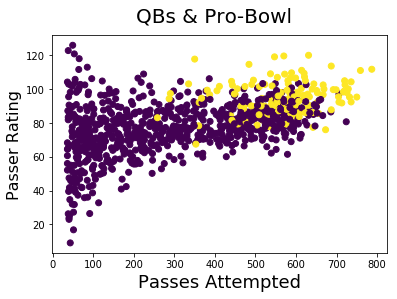

In [6]:
import matplotlib.pyplot as plt

pass_limit = 35

#Removing passers with limited pass sample size
df_passer_by_season_qb = df_passer_by_season.loc[df_passer_by_season['PASS_ATTEMPT'] > pass_limit]


 
plt.scatter(df_passer_by_season_qb.PASS_ATTEMPT, df_passer_by_season_qb.PASS_RAT , c=df_passer_by_season_qb.PASSER_PRO_BOWL)
plt.suptitle('QBs & Pro-Bowl', fontsize=20)
plt.xlabel('Passes Attempted', fontsize=18)
plt.ylabel('Passer Rating', fontsize=16)

In [7]:
#Check how many null values remain for our sample size
df_passer_by_season_qb.isnull().sum()

PASSER                     0
PASSER_SEAS                0
PASSER_PRO_BOWL            0
PASS_RAT                   0
PASS_ATTEMPT               0
COMP                       0
PASSER_DRAFT_SPOT          0
PASSER_DRAFTED             0
DEEP_PASS                  0
MED_PASS                   0
SHORT_PASS                 0
YDS                        0
TD                         0
INTRCPT                    0
PASSER_HGHT                0
PASSER_AGE                 0
PASSER_CAREER_STRT         0
TGT_HGHT                   0
TGT_WGHT                   0
TARGET_PRO_BOWL            0
TGT_AGE                    0
TGT_DRAFT_SPOT             0
TGT_DRAFTED                0
TGT_CAREER_STRT            0
TGT_FORTY                  0
TGT_VERT                   0
RB_TGT                     0
WR_TGT                     0
TE_TGT                     0
TRICK_PLAY                 0
FIRST_DOWN_CONVERSION      0
RED_ZONE_ATTMPT            0
RED_ZONE_QB_RAT            6
FOURTH_DOWN_SUCCESS       60
THIRD_DOWN_SUC

In [8]:
df_passer_by_season_qb_nums_only = df_passer_by_season_qb.drop(['PASSER', 'PASSER_SEAS', 'FREE_PLAY_PASS_RAT'], axis=1)

print("Removed 3 columns to convert all data to numerical, removing missing 4th down data.")
df_passer_by_season_qb_nums_only.head(2)


Removed 3 columns to convert all data to numerical, removing missing 4th down data.


PASSER_PRO_BOWL   PASS_RAT  PASS_ATTEMPT  COMP  \
PASSER   SEAS                                                   
A.Brooks 2000                0  87.492312           271   159   
         2001                0  76.663669           556   312   

               PASSER_DRAFT_SPOT  PASSER_DRAFTED  DEEP_PASS  MED_PASS  \
PASSER   SEAS                                                           
A.Brooks 2000                131               1        0.0       1.0   
         2001                131               1        0.0       1.0   

               SHORT_PASS   YDS     ...      FOURTH_DOWN_SUCCESS  \
PASSER   SEAS                       ...                            
A.Brooks 2000         0.0  2075     ...                 0.750000   
         2001         0.0  3832     ...                 0.363636   

               THIRD_DOWN_SUCCESS  FOURTH_QTR_PASS_RAT   SHOTGUN  NO_HUDDLE  \
PASSER   SEAS                                                                 
A.Brooks 2000            0.402778           109.722222  0.549815        0.0   
         2001            0.406452            76.906566  0.519784        0.0   

               DEF_PENALTY_DCLND  SEAS  GOOD_WEATH  DOME_GAME  TURF_FIELD  
PASSER   SEAS                                                              
A.Brooks 2000                  0  2000    1.000000   0.892989    0.892989  
         2001                  0  2001    0.832734   0.577338    0.629496  

[2 rows x 41 columns]

In [9]:
#Fill in a few missing records with the average
df_passer_by_season_qb_nums_only = df_passer_by_season_qb_nums_only.fillna(df_passer_by_season_qb_nums_only.mean())
df_passer_by_season_qb_nums_only.isnull().sum()

PASSER_PRO_BOWL          0
PASS_RAT                 0
PASS_ATTEMPT             0
COMP                     0
PASSER_DRAFT_SPOT        0
PASSER_DRAFTED           0
DEEP_PASS                0
MED_PASS                 0
SHORT_PASS               0
YDS                      0
TD                       0
INTRCPT                  0
PASSER_HGHT              0
PASSER_AGE               0
PASSER_CAREER_STRT       0
TGT_HGHT                 0
TGT_WGHT                 0
TARGET_PRO_BOWL          0
TGT_AGE                  0
TGT_DRAFT_SPOT           0
TGT_DRAFTED              0
TGT_CAREER_STRT          0
TGT_FORTY                0
TGT_VERT                 0
RB_TGT                   0
WR_TGT                   0
TE_TGT                   0
TRICK_PLAY               0
FIRST_DOWN_CONVERSION    0
RED_ZONE_ATTMPT          0
RED_ZONE_QB_RAT          0
FOURTH_DOWN_SUCCESS      0
THIRD_DOWN_SUCCESS       0
FOURTH_QTR_PASS_RAT      0
SHOTGUN                  0
NO_HUDDLE                0
DEF_PENALTY_DCLND        0
S

In [10]:
##Interactive chart attempt 1

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


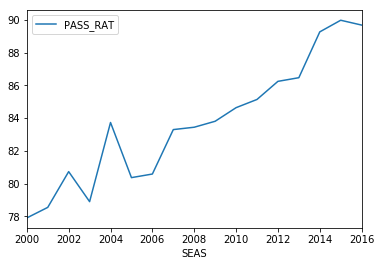

In [11]:
#lets group passes into season average over time
df_pass_seas_avg = df.groupby('SEAS').PASS_RAT.mean()
df_pass_trend = pd.DataFrame(df_pass_seas_avg)

df_pass_trend.plot()


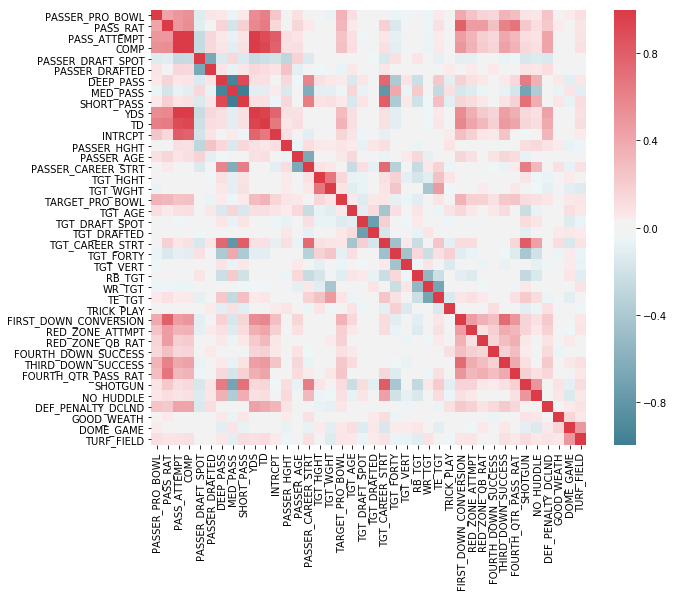

In [12]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_passer_by_season_qb_nums_only.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [13]:
import plotly
plotly.tools.set_credentials_file(username='GTown2018', api_key='MMethJca31qEJ51J4Kan')

import plotly.plotly as py
import plotly.graph_objs as go


df_passer_by_season_probowl = df_passer_by_season.loc[(df_passer_by_season['PASS_ATTEMPT'] > 100) & (df_passer_by_season['PASSER_PRO_BOWL'] == 1)]
df_passer_by_season_qb_non_pb = df_passer_by_season.loc[(df_passer_by_season['PASS_ATTEMPT'] > 100) & (df_passer_by_season['PASSER_PRO_BOWL'] == 0)]


# Create a trace
trace0 = go.Scatter(
    x = df_passer_by_season_probowl.PASS_ATTEMPT,
    y = df_passer_by_season_probowl.PASS_RAT,
    mode = 'markers',
    name = 'Pro-Bowler',
        marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)'),
    text= (df_passer_by_season_probowl['PASSER_SEAS'])

)

trace1 = go.Scatter(
    x = df_passer_by_season_qb_non_pb.PASS_ATTEMPT,
    y = df_passer_by_season_qb_non_pb.PASS_RAT,
    mode = 'markers',
    name = 'Non Pro-Bowler',
        marker = dict(
        size = 5,
        color = 'rgba(0, 152, 200, .8)'),
    text= df_passer_by_season_qb_non_pb['PASSER_SEAS']

)


layout = go.Layout(
    title='QBs & ProBowls',
    xaxis=dict(
        title='Passes Attempted',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Passer Rating',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)



#data = [trace0, trace1]

scatter_pb = go.Figure(data = [trace0, trace1], layout=layout)

# Plot and embed in ipython notebook!
#py.iplot(data)
py.iplot(scatter_pb)


PlotlyRequestError: Account limit reached: Your account is limited to creating 25 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [46]:
df_passer_by_season_qb_nums_only.describe()
#df_passer_by_season_qb_nums_only.isnull().sum()


,PASSER_PRO_BOWL,PASS_RAT,PASS_ATTEMPT,COMP,PASSER_DRAFT_SPOT,PASSER_DRAFTED,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,RED_ZONE_QB_RAT,FOURTH_DOWN_SUCCESS,THIRD_DOWN_SUCCESS,FOURTH_QTR_PASS_RAT,SHOTGUN,NO_HUDDLE,DEF_PENALTY_DCLND,GOOD_WEATH,DOME_GAME,TURF_FIELD
count,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,...,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,0.153422,79.277633,328.767108,200.307947,97.402870,0.858720,0.119630,0.372406,0.507965,2302.781457,...,117.844960,0.421982,0.376176,76.897925,0.459956,0.057885,0.843267,0.918093,0.165924,0.417039
std,0.360593,16.015192,201.685132,129.770188,96.288539,0.348503,0.095443,0.472717,0.383898,1530.461792,...,61.956491,0.262105,0.083519,23.674717,0.269981,0.099366,1.231154,0.124799,0.226126,0.284559
min,0.000000,8.963178,36.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,126.000000,...,-414.583333,0.000000,0.090909,-77.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,70.354846,137.000000,80.000000,8.000000,1.000000,0.000000,0.008087,0.000000,876.500000,...,93.558470,0.250000,0.326854,64.706930,0.236979,0.000000,0.000000,0.868497,0.000000,0.185269
50%,0.000000,79.854009,314.500000,184.000000,60.000000,1.000000,0.157555,0.020663,0.767991,2117.000000,...,120.125639,0.421982,0.382794,78.625772,0.480757,0.024850,0.000000,0.972953,0.074965,0.348729
75%,0.000000,89.724124,515.500000,310.000000,195.500000,1.000000,0.195402,1.000000,0.809668,3626.250000,...,147.395125,0.571429,0.432029,91.132740,0.687926,0.070905,1.000000,1.000000,0.194931,0.674132
max,1.000000,126.062925,787.000000,541.000000,285.000000,1.000000,0.324324,1.000000,0.930233,6402.000000,...,460.416667,1.000000,0.684211,152.361111,0.988701,0.816327,8.000000,1.000000,1.000000,1.000000


In [47]:
df_passer_by_season_qb_nums_only.groupby(['PASSER_DRAFTED']).agg({'PASSER_DRAFTED': np.size})

,PASSER_DRAFTED
PASSER_DRAFTED,
0,128
1,778


In [15]:
import sklearn
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_passer_by_season_qb_nums_only)
   # test_data = scaler.transform(df_passer_by_season_min_pass)
train_data


array([[ 0.        ,  0.67061745,  0.31291611, ...,  1.        ,
         0.89298893,  0.89298893],
       [ 0.        ,  0.57814378,  0.69241012, ...,  0.83273381,
         0.57733813,  0.6294964 ],
       [ 0.        ,  0.60787513,  0.65912117, ...,  0.92090395,
         0.62146893,  0.68549906],
       ..., 
       [ 0.        ,  0.44252005,  0.10386152, ...,  1.        ,
         0.        ,  0.57017544],
       [ 0.        ,  0.63539908,  0.19041278, ...,  1.        ,
         0.        ,  0.17877095],
       [ 0.        ,  0.49654597,  0.17177097, ...,  1.        ,
         0.        ,  0.24848485]])

In [17]:
df_standardized = pd.DataFrame(train_data,index=train_data[:,0])
df_standardized.columns = [
'PASSER_PRO_BOWL',
'PASS_RAT',
'PASS_ATTEMPT',
'COMP',
'PASSER_DRAFT_SPOT',
'PASSER_DRAFTED',
'DEEP_PASS',
'MED_PASS',
'SHORT_PASS',
'YDS',
'TD',
'INTRCPT',
'PASSER_HGHT',
'PASSER_AGE',
'PASSER_CAREER_STRT',
'TGT_HGHT',
'TGT_WGHT',
'TARGET_PRO_BOWL',
'TGT_AGE',
'TGT_DRAFT_SPOT',
'TGT_DRAFTED',
'TGT_CAREER_STRT',
'TGT_FORTY',
'TGT_VERT',
'RB_TGT',
'WR_TGT',
'TE_TGT',
'TRICK_PLAY',
'FIRST_DOWN_CONVERSION',
'RED_ZONE_ATTMPT',
'RED_ZONE_QB_RAT',
'FOURTH_DOWN_SUCCESS',
'THIRD_DOWN_SUCCESS',
'FOURTH_QTR_PASS_RAT',
'SHOTGUN',
'NO_HUDDLE',
'DEF_PENALTY_DCLND',
'SEAS',
'GOOD_WEATH',
'DOME_GAME',
'TURF_FIELD']

df_standardized.head(3)

,PASSER_PRO_BOWL,PASS_RAT,PASS_ATTEMPT,COMP,PASSER_DRAFT_SPOT,PASSER_DRAFTED,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,FOURTH_DOWN_SUCCESS,THIRD_DOWN_SUCCESS,FOURTH_QTR_PASS_RAT,SHOTGUN,NO_HUDDLE,DEF_PENALTY_DCLND,SEAS,GOOD_WEATH,DOME_GAME,TURF_FIELD
0.0,0.0,0.670617,0.312916,0.273764,0.457746,1.0,0.0,1.0,0.0,0.310548,...,0.750000,0.525650,0.814165,0.556099,0.0,0.000,0.0000,1.000000,0.892989,0.892989
0.0,0.0,0.578144,0.692410,0.564639,0.457746,1.0,0.0,1.0,0.0,0.590504,...,0.363636,0.531842,0.671142,0.525725,0.0,0.000,0.0625,0.832734,0.577338,0.629496
0.0,0.0,0.607875,0.659121,0.509506,0.457746,1.0,0.0,1.0,0.0,0.545889,...,0.500000,0.552855,0.693637,0.369524,0.0,0.125,0.1250,0.920904,0.621469,0.685499


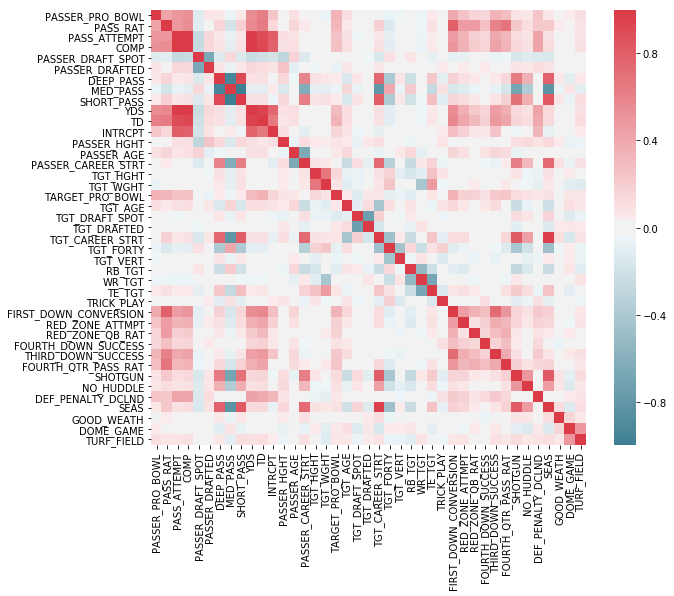

In [18]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_standardized.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [20]:
features = df_standardized.drop(['PASSER_PRO_BOWL'], axis=1)
labels   = df_standardized['PASSER_PRO_BOWL']

##Regularization of Features


In [21]:
list(features)

['PASS_RAT',
 'PASS_ATTEMPT',
 'COMP',
 'PASSER_DRAFT_SPOT',
 'PASSER_DRAFTED',
 'DEEP_PASS',
 'MED_PASS',
 'SHORT_PASS',
 'YDS',
 'TD',
 'INTRCPT',
 'PASSER_HGHT',
 'PASSER_AGE',
 'PASSER_CAREER_STRT',
 'TGT_HGHT',
 'TGT_WGHT',
 'TARGET_PRO_BOWL',
 'TGT_AGE',
 'TGT_DRAFT_SPOT',
 'TGT_DRAFTED',
 'TGT_CAREER_STRT',
 'TGT_FORTY',
 'TGT_VERT',
 'RB_TGT',
 'WR_TGT',
 'TE_TGT',
 'TRICK_PLAY',
 'FIRST_DOWN_CONVERSION',
 'RED_ZONE_ATTMPT',
 'RED_ZONE_QB_RAT',
 'FOURTH_DOWN_SUCCESS',
 'THIRD_DOWN_SUCCESS',
 'FOURTH_QTR_PASS_RAT',
 'SHOTGUN',
 'NO_HUDDLE',
 'DEF_PENALTY_DCLND',
 'SEAS',
 'GOOD_WEATH',
 'DOME_GAME',
 'TURF_FIELD']

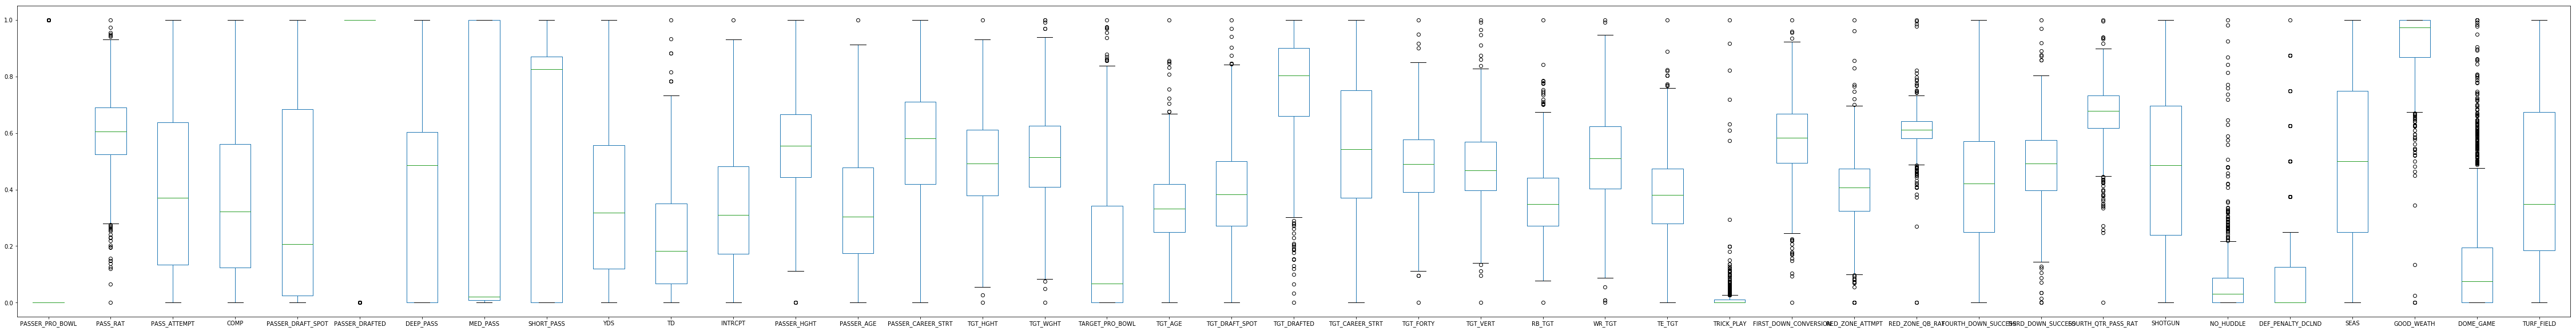

In [42]:
df_standardized.plot.box(figsize=(80,10))

In [48]:
df_standardized.groupby(['PASSER_DRAFTED']).agg({'PASSER_DRAFTED': np.size})

,PASSER_DRAFTED
PASSER_DRAFTED,
0.0,128.0
1.0,778.0


In [23]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
#Regularization
#Lasso L1

model = Lasso()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('PASS_RAT', 0.0), ('PASS_ATTEMPT', 0.0), ('COMP', 0.0), ('PASSER_DRAFT_SPOT', -0.0), ('PASSER_DRAFTED', 0.0), ('DEEP_PASS', 0.0), ('MED_PASS', -0.0), ('SHORT_PASS', 0.0), ('YDS', 0.0), ('TD', 0.0), ('INTRCPT', 0.0), ('PASSER_HGHT', -0.0), ('PASSER_AGE', 0.0), ('PASSER_CAREER_STRT', -0.0), ('TGT_HGHT', -0.0), ('TGT_WGHT', -0.0), ('TARGET_PRO_BOWL', 0.0), ('TGT_AGE', 0.0), ('TGT_DRAFT_SPOT', 0.0), ('TGT_DRAFTED', -0.0), ('TGT_CAREER_STRT', 0.0), ('TGT_FORTY', -0.0), ('TGT_VERT', -0.0), ('RB_TGT', 0.0), ('WR_TGT', -0.0), ('TE_TGT', 0.0), ('TRICK_PLAY', 0.0), ('FIRST_DOWN_CONVERSION', 0.0), ('RED_ZONE_ATTMPT', 0.0), ('RED_ZONE_QB_RAT', 0.0), ('FOURTH_DOWN_SUCCESS', 0.0), ('THIRD_DOWN_SUCCESS', 0.0), ('FOURTH_QTR_PASS_RAT', 0.0), ('SHOTGUN', 0.0), ('NO_HUDDLE', 0.0), ('DEF_PENALTY_DCLND', 0.0), ('SEAS', 0.0), ('GOOD_WEATH', 0.0), ('DOME_GAME', 0.0), ('TURF_FIELD', 0.0)]


In [24]:
model = Ridge()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('PASS_RAT', -0.30218764708172846), ('PASS_ATTEMPT', -0.33858997303769367), ('COMP', 0.3196715451208049), ('PASSER_DRAFT_SPOT', -0.03322294044643136), ('PASSER_DRAFTED', 0.0061903802335522414), ('DEEP_PASS', 0.11074869015665377), ('MED_PASS', -0.013991917331498864), ('SHORT_PASS', -0.023571070031338005), ('YDS', 0.5109727415007802), ('TD', 1.0331069572394604), ('INTRCPT', -0.6586182603002734), ('PASSER_HGHT', -0.09332362593462204), ('PASSER_AGE', -0.05089432560006182), ('PASSER_CAREER_STRT', -0.06790686727946972), ('TGT_HGHT', 0.10773024378595888), ('TGT_WGHT', -0.2154526114545343), ('TARGET_PRO_BOWL', 0.25767195042071683), ('TGT_AGE', 0.039675377049913245), ('TGT_DRAFT_SPOT', 0.10737583500144841), ('TGT_DRAFTED', -0.002957852294830122), ('TGT_CAREER_STRT', 0.013306557656765163), ('TGT_FORTY', -0.028472129639328218), ('TGT_VERT', -0.031312959488724056), ('RB_TGT', 0.07505892560394965), ('WR_TGT', -0.07158599196757695), ('TE_TGT', 0.06562575613345126), ('TRICK_PLAY', 0.0014524187572143

In [25]:
model = ElasticNet()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('PASS_RAT', 0.0), ('PASS_ATTEMPT', 0.0), ('COMP', 0.0), ('PASSER_DRAFT_SPOT', -0.0), ('PASSER_DRAFTED', 0.0), ('DEEP_PASS', 0.0), ('MED_PASS', -0.0), ('SHORT_PASS', 0.0), ('YDS', 0.0), ('TD', 0.0), ('INTRCPT', 0.0), ('PASSER_HGHT', -0.0), ('PASSER_AGE', 0.0), ('PASSER_CAREER_STRT', -0.0), ('TGT_HGHT', -0.0), ('TGT_WGHT', -0.0), ('TARGET_PRO_BOWL', 0.0), ('TGT_AGE', 0.0), ('TGT_DRAFT_SPOT', 0.0), ('TGT_DRAFTED', -0.0), ('TGT_CAREER_STRT', 0.0), ('TGT_FORTY', -0.0), ('TGT_VERT', -0.0), ('RB_TGT', 0.0), ('WR_TGT', -0.0), ('TE_TGT', 0.0), ('TRICK_PLAY', 0.0), ('FIRST_DOWN_CONVERSION', 0.0), ('RED_ZONE_ATTMPT', 0.0), ('RED_ZONE_QB_RAT', 0.0), ('FOURTH_DOWN_SUCCESS', 0.0), ('THIRD_DOWN_SUCCESS', 0.0), ('FOURTH_QTR_PASS_RAT', 0.0), ('SHOTGUN', 0.0), ('NO_HUDDLE', 0.0), ('DEF_PENALTY_DCLND', 0.0), ('SEAS', 0.0), ('GOOD_WEATH', 0.0), ('DOME_GAME', 0.0), ('TURF_FIELD', 0.0)]


In [54]:
corr_matrix = df_standardized.corr().abs()
corr_matrix
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('PASS_ATTEMPT', 'COMP'),
 ('PASS_ATTEMPT', 'YDS'),
 ('PASS_ATTEMPT', 'TD'),
 ('PASS_ATTEMPT', 'INTRCPT'),
 ('COMP', 'YDS'),
 ('COMP', 'TD'),
 ('DEEP_PASS', 'MED_PASS'),
 ('DEEP_PASS', 'SHORT_PASS'),
 ('MED_PASS', 'SHORT_PASS'),
 ('MED_PASS', 'TGT_CAREER_STRT'),
 ('MED_PASS', 'SEAS'),
 ('SHORT_PASS', 'TGT_CAREER_STRT'),
 ('SHORT_PASS', 'SEAS'),
 ('YDS', 'TD'),
 ('TGT_CAREER_STRT', 'SHOTGUN'),
 ('TGT_CAREER_STRT', 'SEAS'),
 ('SHOTGUN', 'SEAS')]